## Import library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import StratifiedKFold
#from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

# wordbatch
import wordbatch
from wordbatch.models import FTRL
from wordbatch.extractors import WordBag
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 2390

## Read data set

In [3]:
path = 'file/'
#path = '../input/'
train = pd.read_csv(path+'train.csv',nrows= 10000)
test = pd.read_csv(path+'test.csv', nrows=10000)
print('Number of rows and columns in the train data set:',train.shape)
print('Number of rows and columns in the test data set:',test.shape)

Number of rows and columns in the train data set: (10000, 8)
Number of rows and columns in the test data set: (10000, 2)


In [13]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


## Target varaible distribution

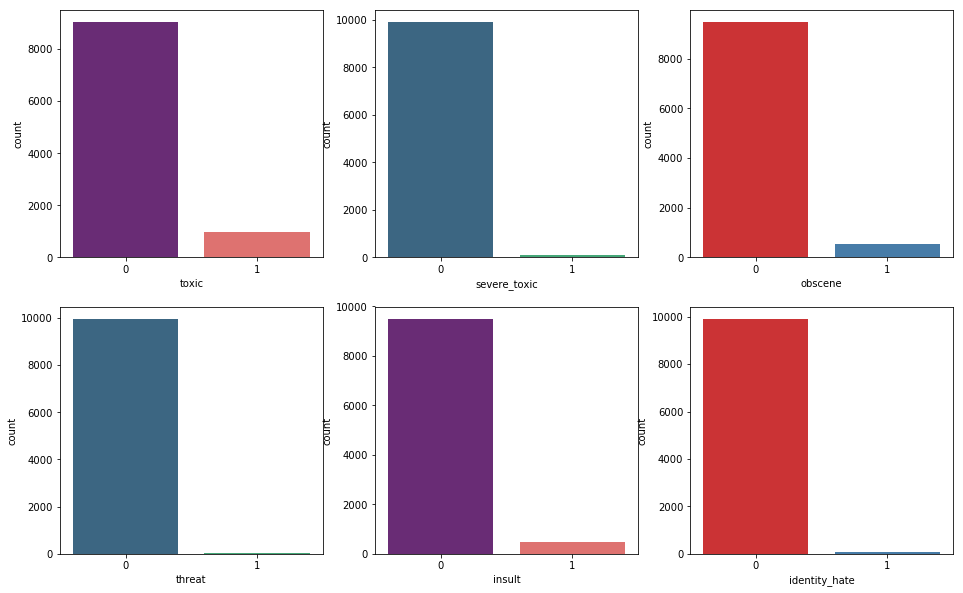

In [5]:
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6);

## Missing value

In [6]:
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
comment_text,0,0.0
toxic,0,NaN
severe_toxic,0,NaN
obscene,0,NaN
threat,0,NaN
insult,0,NaN
identity_hate,0,NaN


## Text preprosesing

In [12]:
wb = wordbatch.WordBatch(extractor= (WordBag, {'hash_ngrams':3,'hash_ngrams_weight':[0.5,1.0],'hash_size':2**20,
                                              'norm':'l2','tf':'log','idf':50.0}))
clf = FTRL(alpha=1, beta=1, L1 = 0.0001, L2 = 1.0, D = 2**20, iters= 1 )

In [14]:
# Bag of word
X = wb.transform(train['comment_text'])
X_test = wb.transform(test['comment_text'])
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]
gc.collect()

Normalize text
Extract wordbags
Normalize text
Extract wordbags


1326

In [23]:
# Model
prd = np.zeros((X_test.shape[0],y.shape[1]))
cv_score_auc =[]
frp,trp = [], []
for i, col in enumerate(y.columns):
    print('Building model for column:',col) 
    clf.fit(X,y[col])
    
    #accuracy
    pred_tr = clf.predict(X)
    f, t, _ = roc_curve(y[col], pred_tr)
    frp.append(f)
    trp.append(t)
    cv_score_auc.append(auc(f,t))
    prd[:,i] = clf.predict(X_test)
    

Building model for column: toxic
Building model for column: severe_toxic
Building model for column: obscene
Building model for column: threat
Building model for column: insult
Building model for column: identity_hate


## Model Validation on train data set

In [24]:
# Mean Auc
np.mean(cv_score_auc)

0.98321871408990791

## Roc AUC curve

Column: toxic
Column: severe_toxic
Column: obscene
Column: threat
Column: insult
Column: identity_hate


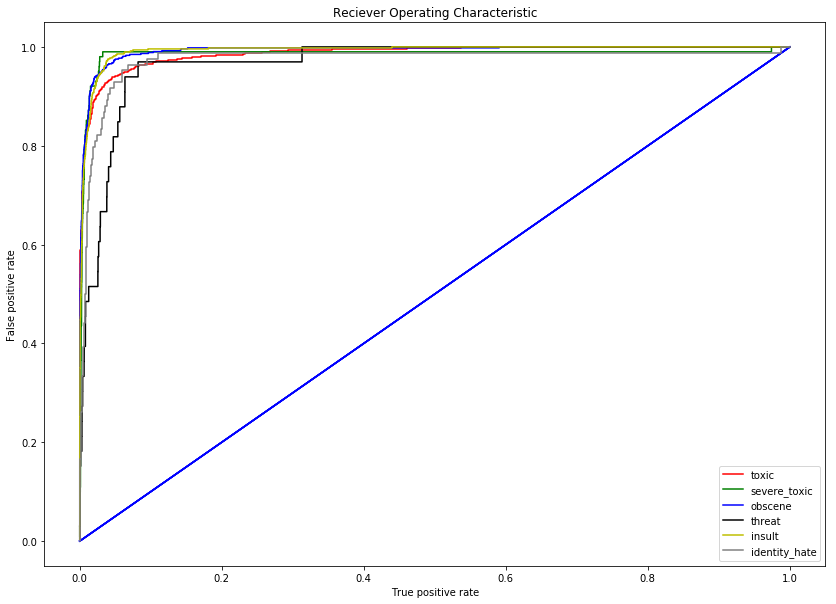

In [28]:
plt.figure(figsize=(14,10))

color = ['r','g','b','k','y','gray']
for i, c in enumerate(target_col):
    print("Column:",c)
    plt.plot([0,1],[0,1],color='b')
    plt.plot(frp[i],trp[i],color=color[i],label= c)
    plt.legend(loc='lower right')
    plt.xlabel('True positive rate')
    plt.ylabel('False positive rate')
    plt.title('Reciever Operating Characteristic')

## submission

In [29]:
prd_1 = pd.DataFrame(prd,columns=y.columns)
submit = pd.concat([test['id'],prd_1],axis=1)
#submit.to_csv('toxic_lr.csv.gz',compression='gzip',index=False)
submit.to_csv('toxic_wordbatch.csv',index=False)
submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.824193,0.124012,0.638103,0.060040,0.590550,0.099719
1,0000247867823ef7,0.028958,0.001548,0.010890,0.000676,0.008476,0.001116
2,00013b17ad220c46,0.065214,0.005857,0.029604,0.003026,0.023755,0.004123
3,00017563c3f7919a,0.014180,0.000601,0.005471,0.000273,0.004820,0.000456
4,00017695ad8997eb,0.029711,0.002153,0.012894,0.001120,0.009031,0.001382


### Thank you